# Categorizando mascotas con redes neuronales

### Introducción

En este cuaderno Jupyter aprenderás a clasificar imágenes de mascotas de forma automática, utilizando la potencia de las redes neuronales convolucionales, la técnica puntera que ha supuesto el _boom_ del Deep Learning.

### Carga de datos
Habremos descargado el conjunto de datos **Oxford pets** del URL <https://www.robots.ox.ac.uk/~vgg/data/pets/> y extraído las imágenes a una carpeta `images`. La siguiente celda organiza los archivos en dos clases (perros y gatos) y en dos subconjuntos (entrenamiento y test) para facilitar las tareas posteriores:

In [1]:
import os

images_path = "images"
annotations_path = "annotations"

trainval = open(os.path.join(annotations_path, "trainval.txt")).readlines()
test = open(os.path.join(annotations_path, "test.txt")).readlines()

os.makedirs(os.path.join(images_path, "train", "cats"), exist_ok=True)
os.makedirs(os.path.join(images_path, "train", "dogs"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "cats"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "dogs"), exist_ok=True)

def classify_image(line, subset):
    basename = line.split(" ")[0]
    species = line.split(" ")[2]
    subfolder = "cats" if species == "1" else "dogs"
    oldpath = os.path.join(images_path, f"{basename}.jpg")
    newpath = os.path.join(images_path, subset, subfolder, f"{basename}.jpg")
    if os.path.isfile(oldpath):
        os.rename(oldpath, newpath)

for line in trainval:
    classify_image(line, "train")

for line in test:
    classify_image(line, "test")

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generador_entrenamiento = ImageDataGenerator()
datos_entrenamiento = generador_entrenamiento.flow_from_directory("images/train")
generador_test = ImageDataGenerator()
datos_test = generador_test.flow_from_directory("images/test", class_mode=None)
algunas_imagenes = next(datos_test)

Found 3680 images belonging to 2 classes.
Found 3669 images belonging to 2 classes.


### Visualización

Podemos visualizar algún ejemplo de imagen a continuación:

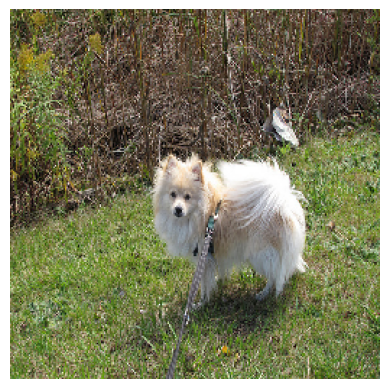

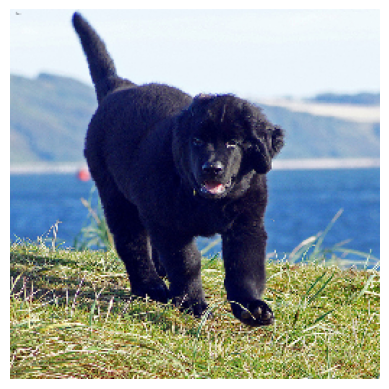

In [3]:
from matplotlib import pyplot as plt
plt.imshow(algunas_imagenes[0]/255.)
plt.axis('off')
plt.show()
plt.imshow(algunas_imagenes[1]/255.)
plt.axis('off')
plt.show()


### Carga del modelo

Nuestro objetivo será crear un modelo capaz de responder a la pregunta "¿Corresponde esta imagen a un gato o a un perro?". En lugar de diseñar una nueva red neuronal desde cero, podemos cargar una red ya construida y, mejor aún, los parámetros optimizados para el conjunto de datos `Imagenet` de todo tipo de imágenes, de forma que nuestra red viene ya "preparada" para reconocer imágenes y no partimos de cero al entrenar. Esta estrategia se conoce como _transfer learning_.

Importaremos la red InceptionV3 desde la biblioteca de modelos ya entrenados de Tensorflow. Esta red se basa en un componente llamado "bloque Inception": encadena varios de estos bloques para extraer información de la imagen.

indica que el tamaño de las imagenes sera de 256x256 pixeles y tendrá los colores RGB
input_shape=(256, 256, 3)

In [4]:
from tensorflow.keras import applications
inception = applications.InceptionV3(include_top=False, input_shape=(256, 256, 3))

87910968/87910968 [==============================] - 3s 0us/step


### Ajustes del modelo

En la siguiente celda añadimos a la red InceptionV3 un par de capas que nos permiten obtener una predicción a partir de la información que haya inferido de la imagen.

Básicamente sustituimos la última capa de esta red, que es la que hace la clasificación final, por nuestras propias capas para que simplemente clasifique las imágenes en perros o gatos (o lo que nos interese según el caso) con un par de funciones de activación que nos darán unos ajustes muy interesantes para afinar mejor los resultados.

Flatten --> es una capa que agregamos para aplanar los datos si vienen en 2 ó más dimensiones

Dense(128, activation="relu") ---> Esta capa que incluimos nos permite descartar valores negativos tomar solo los valores positivos

Dense(2, activation="softmax") --> es la capa para las dos unidas, una para el perro y otra para el gato. Y la activación sofmax nos 
convertira los valores a probabilidades. 

modelo = Sequential([inception, predictor]) -> nos permite crear una sequencia con estas dos ultimas capas

modelo.compile(optimizer="adam", loss="categorical_crossentropy") --> Nos permite agregar un proceso de optimización de los recursos; en el caso de una red neuronal de clasificación debemos usar la función categorical_crossentropy, en cada fase proporciona feedback al modelo si esta clasificando de manera correcta. 

In [5]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
predictor = Sequential([
    Flatten(), 
    Dense(128, activation="relu"), 
    Dense(2, activation="softmax")
])
modelo = Sequential([inception, predictor])
modelo.compile(optimizer="adam", loss="categorical_crossentropy")

### Entrenamiento

Una vez creado el modelo que ya tiene la estructura final para responder preguntas de "sí/no", ajustamos sus parámetros (que inicialmente son aleatorios) al conjunto de imágenes que vamos a utilizar para entrenar:

Epochs -> Nos ayuda a poner el numero de veces que pasará el dataset completo.

In [6]:
modelo.fit(datos_entrenamiento, epochs=50)

Epoch 1/50
115/115 [==============================] - 400s 3s/step - loss: 1.4414
Epoch 2/50
115/115 [==============================] - 374s 3s/step - loss: 0.6320
Epoch 3/50
115/115 [==============================] - 377s 3s/step - loss: 0.5961
Epoch 4/50
115/115 [==============================] - 364s 3s/step - loss: 0.5778
Epoch 5/50
115/115 [==============================] - 353s 3s/step - loss: 0.5378
Epoch 6/50
115/115 [==============================] - 351s 3s/step - loss: 0.4806
Epoch 7/50
115/115 [==============================] - 351s 3s/step - loss: 0.3786
Epoch 8/50
115/115 [==============================] - 354s 3s/step - loss: 0.3607
Epoch 9/50
115/115 [==============================] - 356s 3s/step - loss: 0.2468
Epoch 10/50
115/115 [==============================] - 366s 3s/step - loss: 0.2015
Epoch 11/50
115/115 [==============================] - 360s 3s/step - loss: 0.1307
Epoch 12/50
115/115 [==============================] - 365s 3s/step - loss: 0.0901
Epoch 13/50
1

### Predicción

Nuestro modelo ya está listo. En la siguiente celda tomamos algunas imágenes del subconjunto de test (imágenes que nunca han sido vistas por la red neuronal) y comprobamos cuáles son las predicciones del modelo: ¿acertará todos los perros y gatos?

clase = np.argmax(probs, -1) --> no va indicar cual de columnas tiene la mayo probabilidad entre Perro y gato

In [7]:
lote_test = next(datos_test)

probs = modelo.predict(lote_test)
import numpy as np
clase = np.argmax(probs, -1)

1/1 [==============================] - 1s 1s/step


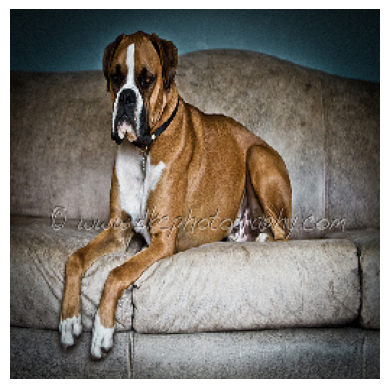

Predicción: gato


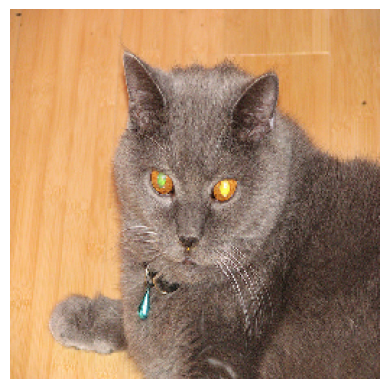

Predicción: perro


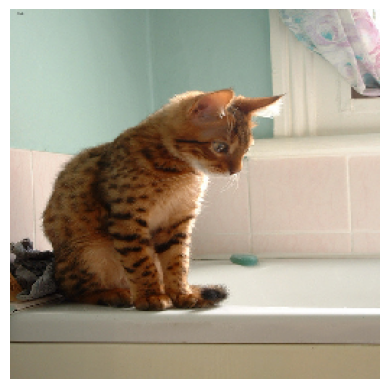

Predicción: perro


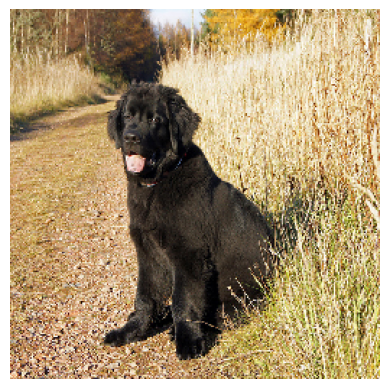

Predicción: perro


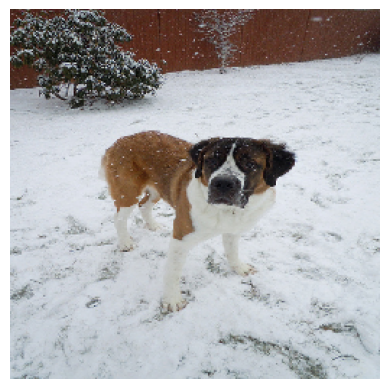

Predicción: perro


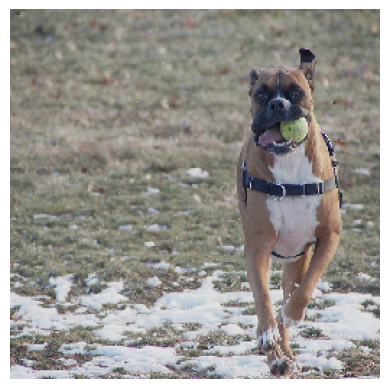

Predicción: perro


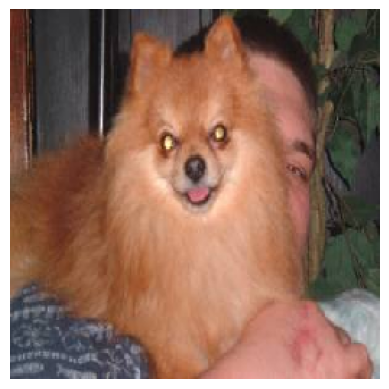

Predicción: perro


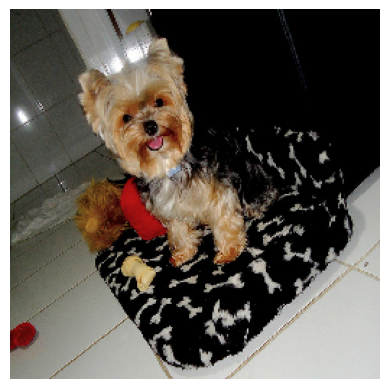

Predicción: gato


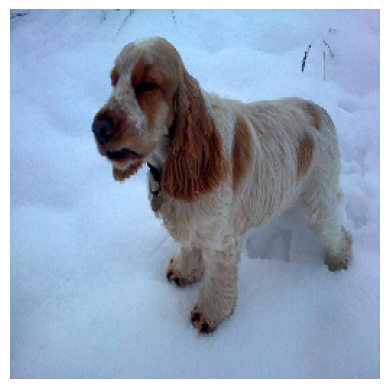

Predicción: gato


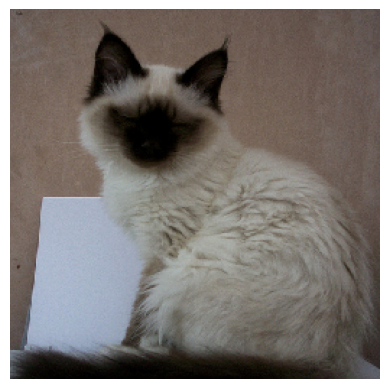

Predicción: perro


In [8]:
mostrar_imagenes = 10

for i in range(mostrar_imagenes):
    plt.imshow(lote_test[i]/255.)
    plt.axis('off')
    plt.show()
    print("Predicción:", "perro" if clase[i] else "gato")